# Character Sequence Text Generation

Di sini kita akan membuat language model untuk membangkitkan text dari level karakter berdasarkan input sekuens karakter yang diberikan

In [0]:
!pip install tensorflow-gpu

     |████████████████████████████████| 380.8MB 44kB/s 
     |████████████████████████████████| 450kB 51.9MB/s 
     |████████████████████████████████| 3.8MB 50.9MB/s 
     |████████████████████████████████| 81kB 10.4MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.1 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorboard 2.0.1 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.6.3 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled goog

In [0]:



















import tensorflow as tf

from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Reshape
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import get_file

import numpy as np
import random
import sys
import io

# Text Data
Untuk memulainya, kita perlu memiliki data untuk melatih model kita. Anda dapat menggunakan file teks apa pun yang Anda inginkan untuk proses ini

di sini telah disediakan beberapa data text yang bisa digunakan

In [0]:
dataset = {
    'shakespeare'  : 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt',
    'wonderland'   : 'https://www.gutenberg.org/cache/epub/11/pg11.txt',
    'harry'        : 'https://www.linguistik.uzh.ch/dam/jcr:169bff5c-ac13-457b-9acb-4fe7f1ad5cb0/Harry%20Potter%20and%20the%20Sorcerer.txt',
    'nietzsche'    : 'https://s3.amazonaws.com/text-datasets/nietzsche.txt',
    'frankenstein' : 'https://www.gutenberg.org/files/84/84-0.txt',
    'liriklagu'    : 'https://raw.githubusercontent.com/dhamirdesrul/Text-Generation/master/lagupeterpan.txt'
}

Pilih satu data

In [0]:
# inisilisasi variable filename dengan file dataset
filename = dataset['liriklagu'] #hapus
path = get_file( filename.split('/')[-1], origin=filename)


16384/12206 [========================================] - 0s 0us/step


# **Preprocessing**

Semua data akan dilakukan prapemrosesan, data tersebut akan dibersihkan seperti: 
- Menghapus karakter yang tidak diperlukan
- lowercase

In [0]:
# import regex
import re #hapus


kalimat = ''
with io.open(path, encoding='utf-8') as f:
    text = f.read().lower()

# melakukan preprocessing dengan menghilangkan "'", "\n", ".", "-", ","
kalimat = re.sub('[\n\,\-\'\.]', ' ', text) #hapus
text = kalimat
text[:250]

'kudapat melintas bumi kudapat merajai hari kudapat melukis langit kudapat buatmu berseri tapi kudapat melangkah pergi bila kau tipu aku disini kudapat melangkah pergi ku dapat itu tapi buka dulu topengmu buka dulu topengmu biar kulihat warnamu kan ku'

# Encoding
Jaringan saraf bekerja dengan angka, bukan karakter teks. Jadi kita perlu mengkonversi input karakter menjadi angka. 

Pertama, kita urutkan daftar unik semua karakter yang muncul dalam teks tersebut, kemudian gunakan fungsi enumerasi untuk mendapatkan angka yang mewakili karakter tersebut. 

Berikutnya buat kamus yang menyimpan kunci dan nilai, atau karakter dan angka yang mewakili mereka.

In [0]:
chars = sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))
print(indices_char)
print(char_indices)

total chars: 24
{0: ' ', 1: '?', 2: 'a', 3: 'b', 4: 'c', 5: 'd', 6: 'e', 7: 'f', 8: 'g', 9: 'h', 10: 'i', 11: 'j', 12: 'k', 13: 'l', 14: 'm', 15: 'n', 16: 'o', 17: 'p', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'w', 23: 'y'}
{' ': 0, '?': 1, 'a': 2, 'b': 3, 'c': 4, 'd': 5, 'e': 6, 'f': 7, 'g': 8, 'h': 9, 'i': 10, 'j': 11, 'k': 12, 'l': 13, 'm': 14, 'n': 15, 'o': 16, 'p': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'w': 22, 'y': 23}


# Sequence Building

Di sini kita set bahwa maksimum sequence dari karakter input adalah 40

Untuk itu, kita harus memotong semua text dalam bentuk sekuens semi-redundan sepanjang 40 karakter. Kita gunakan nilai redundansi sebesar 3 karakter

artinya, misal kita memiliki teks: `"saya suka makan nasi"`, kemudian kita buat sekuens semi-redundan dengan panjang 5 dan redundansi 2, maka kita akan memiliki
* `'saya '` dengan target `'aya s'`
* `'ya su'` dengan target `'a suk'`
* `' suka'` dengan target `'suka '`
* `'uka m'` dengan target `'ka ma'`
* dan seterusnya


In [0]:
# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40 #hapus
step = 3 #hapus
sentences = []
next_chars = []

for i in range(0, len(text) - maxlen, step):
    # memasukkan text ke dalam sentences
    sentences.append(text[i: i + maxlen]) #hapus
    
    #memasukkan text selanjutnya ke dalam next_chars
    next_chars.append(text[i+1 : i + maxlen+1]) #hapus
    
print('nb sequences:', len(sentences))

nb sequences: 4056


In [0]:
for i in range(10):
  print([sentences[i]],[next_chars[i]])

['kudapat melintas bumi kudapat merajai ha'] ['udapat melintas bumi kudapat merajai har']
['apat melintas bumi kudapat merajai hari '] ['pat melintas bumi kudapat merajai hari k']
['t melintas bumi kudapat merajai hari kud'] [' melintas bumi kudapat merajai hari kuda']
['elintas bumi kudapat merajai hari kudapa'] ['lintas bumi kudapat merajai hari kudapat']
['ntas bumi kudapat merajai hari kudapat m'] ['tas bumi kudapat merajai hari kudapat me']
['s bumi kudapat merajai hari kudapat melu'] [' bumi kudapat merajai hari kudapat meluk']
['umi kudapat merajai hari kudapat melukis'] ['mi kudapat merajai hari kudapat melukis ']
[' kudapat merajai hari kudapat melukis la'] ['kudapat merajai hari kudapat melukis lan']
['dapat merajai hari kudapat melukis langi'] ['apat merajai hari kudapat melukis langit']
['at merajai hari kudapat melukis langit k'] ['t merajai hari kudapat melukis langit ku']


Berikutnya kita buat data latih dan targetnya berupa vektor angka yang diambil dari dictionary berdasarkan kalimat sekuens yang sudah kita buat

In [0]:
# print('Vectorization...')
# menginisialisasi x dan y berisikan matriks kosong sebesar 3x3 menggunakan sentences, maxlen, dan chars

x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool) #hapus
y = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool) #hapus


# melibatkan hasil encoding diatas
# mengisi x dengan nilai 1 berdasarkan jumlah index kalimat, index karakter, index karakter dalam char_indicies
#hapus
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
      print(t, char)
      x[i, t, char_indices[char]] = 1
        

# mengisi y dengan nilai 1 berdasarkan jumlah index kalimat selanjutnya, index karakter selanjutnya, jumlah karakter selanjutnya
# hapus
for i, sentence in enumerate(next_chars):
    for t, char in enumerate(sentence):
        y[i, t, char_indices[char]] = 1
        


0 k
1 u
2 d
3 a
4 p
5 a
6 t
7  
8 m
9 e
10 l
11 i
12 n
13 t
14 a
15 s
16  
17 b
18 u
19 m
20 i
21  
22 k
23 u
24 d
25 a
26 p
27 a
28 t
29  
30 m
31 e
32 r
33 a
34 j
35 a
36 i
37  
38 h
39 a
0 a
1 p
2 a
3 t
4  
5 m
6 e
7 l
8 i
9 n
10 t
11 a
12 s
13  
14 b
15 u
16 m
17 i
18  
19 k
20 u
21 d
22 a
23 p
24 a
25 t
26  
27 m
28 e
29 r
30 a
31 j
32 a
33 i
34  
35 h
36 a
37 r
38 i
39  
0 t
1  
2 m
3 e
4 l
5 i
6 n
7 t
8 a
9 s
10  
11 b
12 u
13 m
14 i
15  
16 k
17 u
18 d
19 a
20 p
21 a
22 t
23  
24 m
25 e
26 r
27 a
28 j
29 a
30 i
31  
32 h
33 a
34 r
35 i
36  
37 k
38 u
39 d
0 e
1 l
2 i
3 n
4 t
5 a
6 s
7  
8 b
9 u
10 m
11 i
12  
13 k
14 u
15 d
16 a
17 p
18 a
19 t
20  
21 m
22 e
23 r
24 a
25 j
26 a
27 i
28  
29 h
30 a
31 r
32 i
33  
34 k
35 u
36 d
37 a
38 p
39 a
0 n
1 t
2 a
3 s
4  
5 b
6 u
7 m
8 i
9  
10 k
11 u
12 d
13 a
14 p
15 a
16 t
17  
18 m
19 e
20 r
21 a
22 j
23 a
24 i
25  
26 h
27 a
28 r
29 i
30  
31 k
32 u
33 d
34 a
35 p
36 a
37 t
38  
39 m
0 s
1  
2 b
3 u
4 m
5 i
6  
7 k
8 u
9 d
10 a
11 p


# LSTM Model
Sekarang kita coba bangun jaringan sederhana mengguankan 1 layer LSTM dengan ukuran output vektor 128. Setelah layer LSTM, kita tambahkan Layer Dense untuk memprediksi kelanjutan karakter dari 40 karakter input

Many to Many RNN

![alt text](https://indoml.files.wordpress.com/2018/03/kind-many-to-many2.jpg)

In [0]:
#inisialisasi model dengan squential
model = Sequential()
# menambahkan model dengan LSTM sebanyak 256, input_shape diisi maxlen, panjang karakter, dan parameter return_sequences
model.add(LSTM(256, input_shape=(maxlen, len(chars)), return_sequences=True))
model.add(LSTM(256, return_sequences=True))

# menambahkan model dengan dense sebanyak panjang karakter dan aktivasi menggunakan softmax
model.add(TimeDistributed(Dense(len(chars), activation='softmax')))

#menambahkan model dengan melakukan reshape dengan maxlen dan panjang karakter
model.add(Reshape((maxlen, len(chars))))

#melakukan optimizer menggunakan 'adam' dengan learning rate sebesar 0.01
optimizer = Adam(lr=0.01)
# model akan di compile menggunakan parameter loss 'categorical_crossentropy' dan optimizer 'adam'
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

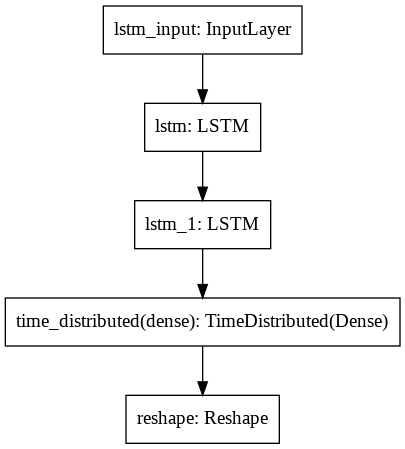

In [0]:
# Menampilkan layer yang telah dibuat
from tensorflow.keras.utils import plot_model
plot_model(model)

# Sample Probability Function
Berikut adalah helper function untuk melakukan sampling karakter output berdasarkan output probability dari softmax

In [0]:
def sample(preds, temperature=1.0):

  """

  Inputs:
  - preds: prediksi model
  - temperature: temperatur diisi dengan 1.0

  Outputs:
  Nilai probabilitas 
  """
  # helper function to sample an index from a probability array
  preds = np.asarray(preds).astype('float64')
  preds = np.log(preds) / temperature
  exp_preds = np.exp(preds)
  preds = exp_preds / np.sum(exp_preds)
  probas = np.random.multinomial(1, preds, 1)
  return np.argmax(probas)


# Training Checkpoint
Berikutnya mari kita tambahkan sebuah callback pada fungsi training agar kita bisa melihat contoh hasil pembangkitan text yang dilakukan setiap 5 epoch

In [0]:
def on_epoch_end(epoch, _):
  if epoch%5==0:
    # Function invoked at end of each epoch. Prints generated text.
    print('\n---------------------------------------------------------------------')
    print('>>>>> Generating text after Epoch: %d' % epoch)

    # mencari nilai random dari index 0 sampai jumlah text-maxlen-1
    start_index = random.randint(0, len(text) - maxlen - 1) 
    # dhamir masih belum tau
    diversity = 0.7
    print('\n>>>>> diversity:', diversity)

    generated = ''
    # menginisialisasi sentence pada text dengan index [start_index: start_index + maxlen]
    sentence = text[start_index: start_index + maxlen]
    # menambahkan variable generate dengan value sentence
    generated += sentence
    print('>>>>> Generating with seed: "' + sentence + '"')
    sys.stdout.write(generated)

    # input nilai a berdasarkan jumlah output karakter yang diinginkan
    a = 100
    for i in range(a):
        # menginisiasi x_pred menggunakan matrix 0 dengan ukuran 1x maxlen x panjang karakter
        x_pred = np.zeros((1, maxlen, len(chars)))
        # mengisi x_pred dengan nilai 1 berdasarkan index [0, index karakter, dan jumlah karakter]
        for t, char in enumerate(sentence):
            x_pred[0, t, char_indices[char]] = 1.
        
        # menginisialisasi preds dengan hasil prediksi model dengan parameter x_pred dan verbose=0 indeks 0
        preds = model.predict(x_pred, verbose=0)[0]
        # menginisialisasi next_index dengan sampling karakter
        next_index = sample(preds[-1], diversity)
        # menginisialisasi next_char dengan karakter berdasarkan index dalam indicies_char index [next_char]
        next_char = indices_char[next_index]
        # menambahkan generated dengan  value next_char
        generated += next_char
        # menginisiasi sentence dengan value sentences dari index [1: ] ditambahkan dengan value next_char
        sentence = sentence[1:] + next_char

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print('\n---------------------------------------------------------------------')
    print('>>>>> Continuing training')
        
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

# Training Process

Sekarang tinggal kita latih model Text Generator kita

In [0]:
model.fit(x, y,
          batch_size=512,
          epochs=50,
          callbacks=[print_callback])

Train on 4056 samples
Epoch 1/50
3584/4056 [=========================>....] - ETA: 0s - loss: 3.3445
---------------------------------------------------------------------
>>>>> Generating text after Epoch: 0

>>>>> diversity: 0.7
>>>>> Generating with seed: "an senyummu semua tentangmu tentangku ha"
an senyummu semua tentangmu tentangku haiadmllgirpbnn hrrauiskrselipgapsaeuauuanmsginuirh lbaikd uakhitgnlasbhdn nhkr gesiniarhkihdhldrssrnd
---------------------------------------------------------------------
>>>>> Continuing training
4056/4056 [==============================] - 12s 3ms/sample - loss: 3.2961
Epoch 2/50
4056/4056 [==============================] - 1s 194us/sample - loss: 2.7515
Epoch 3/50
4056/4056 [==============================] - 1s 174us/sample - loss: 2.6928
Epoch 4/50
4056/4056 [==============================] - 1s 174us/sample - loss: 2.6103
Epoch 5/50
4056/4056 [==============================] - 1s 174us/sample - loss: 2.4415
Epoch 6/50
3584/4056 [=================

# Testing Process
setelah model terlatih, mari kita uji untuk membangkitkan text sepanjang 400 karakter

In [0]:
input_kata = input()
index_kata = text.index(input_kata)
index_kata

awan


5265

In [0]:
# start_index = random.randint(0, len(text) - maxlen - 1)
diversity = 0.7
print('\n>>>>> diversity:', diversity)

#menginisialisasi generated dengan string kosong
generated = ''
#menginisialisasi sentence denga text berdasarkan index [index_kata: index_kata + maxlen]
sentence = text[index_kata: index_kata + maxlen]
#menambahkan generated dengan value sentence
generated += sentence
print('>>>>> Generating with seed: "' + sentence + '"')
sys.stdout.write(generated)

# input nilai a berdasarkan jumlah output karakter yang diinginkan
a = 200
for i in range(a):
    x_pred = np.zeros((1, maxlen, len(chars)))
    for t, char in enumerate(sentence):
        x_pred[0, t, char_indices[char]] = 1.

    # menginisialisasi preds dengan hasil prediksi model dengan parameter x_pred dan verbose=0 indeks 0
    preds = model.predict(x_pred, verbose=0)[0]
    # menginisialisasi next_index dengan sampling karakter
    next_index = sample(preds[-1], diversity)
    # menginisialisasi next_char dengan karakter berdasarkan index dalam indicies_char index [next_char]
    next_char = indices_char[next_index]
    
    # menambahkan generated dengan  value next_char
    generated += next_char
    # menginisiasi sentence dengan value sentences dari index [1: ] ditambahkan dengan value next_char
    sentence = sentence[1:] + next_char

    sys.stdout.write(next_char)
    sys.stdout.flush()



>>>>> diversity: 0.7
>>>>> Generating with seed: "awan merangkai mimpi dengan khayalku sel"
awan merangkai mimpi dengan khayalku selalu bermimpi dengan hariku pernah kau lihat bintang bersinar putih penuh harapan tangan halusnya terbuka coba temani dekati aku selalu terangi gelap malamku dan rasakan semua bintang memanggil tawamu 

<p>Copyright &copy; 2019 <a href=https://www.linkedin.com/in/andityaarifianto/>ADF</a> </p>